# Gene Set Enrichment Analysis using Fisher Exact Test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import pickle
import seaborn as sns
from scipy.stats import fisher_exact
import gseapy as gp
from scipy.stats import hypergeom

Read in the required data

In [2]:
datExpr = pd.read_csv('/ReCoDE-Gene-Network-Analysis/data/data/Bcell_datExpr_pseudobulk.csv', index_col = 0)

In [3]:
with open('/ReCoDE-Gene-Network-Analysis/data/other/separated_communities.pkl', 'rb') as file:
        separated_communities = pickle.load(file)

In [4]:
# Convert each module in separated_communities to a set
modules = {f'Module_{i+1}': set(community) for i, community in enumerate(separated_communities)}

In [5]:
modules

{'Module_1': {'AKAP14',
  'ANKRD29',
  'ANO1',
  'ARHGAP23',
  'ARHGEF39',
  'C21orf62',
  'CC2D2B',
  'CCNA1',
  'CDH6',
  'CFAP99',
  'CNKSR3',
  'CYYR1',
  'DBX2',
  'DENND6A-AS1',
  'DEPDC7',
  'DTNA',
  'FNDC5',
  'GJB6',
  'GJC2',
  'GNG12',
  'HCG9',
  'HYDIN',
  'IGLC4',
  'IGLV5-37',
  'KLHL13',
  'KRT2',
  'LAMA2',
  'LCN2',
  'LIM2',
  'LIN28A',
  'LINC00640',
  'LINC00997',
  'LINC01133',
  'LINC01832',
  'LINC01891',
  'LINC02267',
  'LNCOC1',
  'MGAM',
  'MOBP',
  'MUCL3',
  'NGFR',
  'NKD2',
  'NKX6-3',
  'OPA1-AS1',
  'OR2B11',
  'PHACTR3',
  'PLSCR2',
  'PRLR',
  'PRRT3-AS1',
  'PTGES',
  'RARRES2',
  'REG1A',
  'RNF182',
  'SLC10A5',
  'SLC17A7',
  'SLC26A8',
  'SLC28A2',
  'SLC2A4',
  'SLC6A3',
  'SRRM5',
  'STAP2',
  'STARD6',
  'TDRD1',
  'TDRP',
  'TECTA',
  'TMEM255A',
  'TMEM72-AS1',
  'ZC2HC1B',
  'ZNF462',
  'ZSCAN10'},
 'Module_2': {'ACTN3',
  'ACVR2B-AS1',
  'C10orf105',
  'CALML6',
  'CDC42EP1',
  'DLGAP2',
  'DPYD-IT1',
  'EPHB2',
  'ESCO2',
  'FAM174A-DT'

# Step 1: Load in Gene-Sets

This exercise will show how to use GMT files that contain gene-set information downloaded from the Human MSigDB Collections database.

In [6]:
#Load the GMT file
def read_gmt_file(file_path):
    gene_sets = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            gene_set_name = parts[0]
            genes = parts[2:]
            gene_sets[gene_set_name] = set(genes)
    return gene_sets

In [7]:
gmt_file = '/ReCoDE-Gene-Network-Analysis/data/other/h.all.v2023.2.Hs.symbols.gmt'
gene_sets = read_gmt_file(gmt_file)

In [8]:
gene_sets

{'HALLMARK_ADIPOGENESIS': {'ABCA1',
  'ABCB8',
  'ACAA2',
  'ACADL',
  'ACADM',
  'ACADS',
  'ACLY',
  'ACO2',
  'ACOX1',
  'ADCY6',
  'ADIG',
  'ADIPOQ',
  'ADIPOR2',
  'AGPAT3',
  'AIFM1',
  'AK2',
  'ALDH2',
  'ALDOA',
  'ANGPT1',
  'ANGPTL4',
  'APLP2',
  'APOE',
  'ARAF',
  'ARL4A',
  'ATL2',
  'ATP1B3',
  'ATP5PO',
  'BAZ2A',
  'BCKDHA',
  'BCL2L13',
  'BCL6',
  'C3',
  'CAT',
  'CAVIN1',
  'CAVIN2',
  'CCNG2',
  'CD151',
  'CD302',
  'CD36',
  'CDKN2C',
  'CHCHD10',
  'CHUK',
  'CIDEA',
  'CMBL',
  'CMPK1',
  'COL15A1',
  'COL4A1',
  'COQ3',
  'COQ5',
  'COQ9',
  'COX6A1',
  'COX7B',
  'COX8A',
  'CPT2',
  'CRAT',
  'CS',
  'CYC1',
  'CYP4B1',
  'DBT',
  'DDT',
  'DECR1',
  'DGAT1',
  'DHCR7',
  'DHRS7',
  'DHRS7B',
  'DLAT',
  'DLD',
  'DNAJB9',
  'DNAJC15',
  'DRAM2',
  'ECH1',
  'ECHS1',
  'ELMOD3',
  'ELOVL6',
  'ENPP2',
  'EPHX2',
  'ESRRA',
  'ESYT1',
  'ETFB',
  'FABP4',
  'FAH',
  'FZD4',
  'G3BP2',
  'GADD45A',
  'GBE1',
  'GHITM',
  'GPAM',
  'GPAT4',
  'GPD2',
  'GPHN

# Step 2: Calculate Fisher's Exact Test for Enrichment

In [9]:
# Container for results
results = []

# Iterate over each module
for module_name, module_genes in modules.items():
    module_genes_in_expr = module_genes.intersection(datExpr.columns)
    
    # Check if module_genes_in_expr is empty to avoid issues
    if len(module_genes_in_expr) == 0:
        continue

    # Iterate over each gene set in the GMT file
    for gene_set_name, gene_set_genes in gene_sets.items():
        overlap_genes = module_genes_in_expr.intersection(gene_set_genes)
        non_overlap_module_genes = module_genes_in_expr.difference(gene_set_genes)
        non_overlap_gene_set_genes = gene_set_genes.difference(module_genes_in_expr)

        # Calculate the contingency table
        a = len(overlap_genes)
        b = len(non_overlap_module_genes)
        c = len(non_overlap_gene_set_genes)
        d = len(set(datExpr.columns)) - (a + b + c)  # Adjust d to only consider genes in datExpr
        
        # Ensure all values in the contingency table are non-negative
        if a < 0 or b < 0 or c < 0 or d < 0:
            continue

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='two-sided')
        
        results.append({
            'Module': module_name,
            'Gene Set': gene_set_name,
            'Overlap Count': a,
            'Odds Ratio': odds_ratio,
            'P-value': p_value
        })


In [10]:
# Convert results to DataFrame for further analysis
results_df = pd.DataFrame(results)

# Adjust p-values for multiple testing
results_df['Adjusted P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

# Display results
print(results_df)

        Module                             Gene Set  Overlap Count  \
0     Module_1                HALLMARK_ADIPOGENESIS              0   
1     Module_1         HALLMARK_ALLOGRAFT_REJECTION              0   
2     Module_1           HALLMARK_ANDROGEN_RESPONSE              0   
3     Module_1                HALLMARK_ANGIOGENESIS              0   
4     Module_1             HALLMARK_APICAL_JUNCTION              1   
..         ...                                  ...            ...   
895  Module_18   HALLMARK_UNFOLDED_PROTEIN_RESPONSE              0   
896  Module_18              HALLMARK_UV_RESPONSE_DN              0   
897  Module_18              HALLMARK_UV_RESPONSE_UP              0   
898  Module_18  HALLMARK_WNT_BETA_CATENIN_SIGNALING              0   
899  Module_18       HALLMARK_XENOBIOTIC_METABOLISM              0   

     Odds Ratio       P-value  Adjusted P-value  
0      0.000000  1.776694e-07          0.000011  
1      0.000000  1.776694e-07          0.000011  
2      0.

Let's focus on one module for the purpose of the enrichment analysis:

In [11]:
# Filter for Module 1 and sort by overlap count
module_1_results = results_df[results_df['Module'] == 'Module_1']
top_10_enriched_gene_sets = module_1_results.sort_values(by='Overlap Count', ascending=False).head(10)

print(top_10_enriched_gene_sets)

      Module                                    Gene Set  Overlap Count  \
15  Module_1             HALLMARK_ESTROGEN_RESPONSE_LATE              3   
13  Module_1  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION              2   
33  Module_1                         HALLMARK_MYOGENESIS              2   
27  Module_1                  HALLMARK_KRAS_SIGNALING_DN              2   
49  Module_1              HALLMARK_XENOBIOTIC_METABOLISM              2   
5   Module_1                     HALLMARK_APICAL_SURFACE              1   
21  Module_1                            HALLMARK_HYPOXIA              1   
28  Module_1                  HALLMARK_KRAS_SIGNALING_UP              1   
9   Module_1                        HALLMARK_COAGULATION              1   
42  Module_1                    HALLMARK_SPERMATOGENESIS              1   

    Odds Ratio   P-value  Adjusted P-value  
15    0.166604  0.000164          0.004928  
13    0.108734  0.000034          0.001084  
33    0.108734  0.000034          0.001

In [12]:
#Extract data for plotting (top 10 pathways with highest overlap count)
top_10_enriched_gene_sets
y_labels = top_10_enriched_gene_sets['Gene Set']
x = top_10_enriched_gene_sets['Odds Ratio']
sizes = top_10_enriched_gene_sets['Overlap Count'] * 20
p_values = top_10_enriched_gene_sets['P-value']
adjusted_p_values = top_10_enriched_gene_sets['Adjusted P-value']

# Step 3: Visualise Enriched Pathways

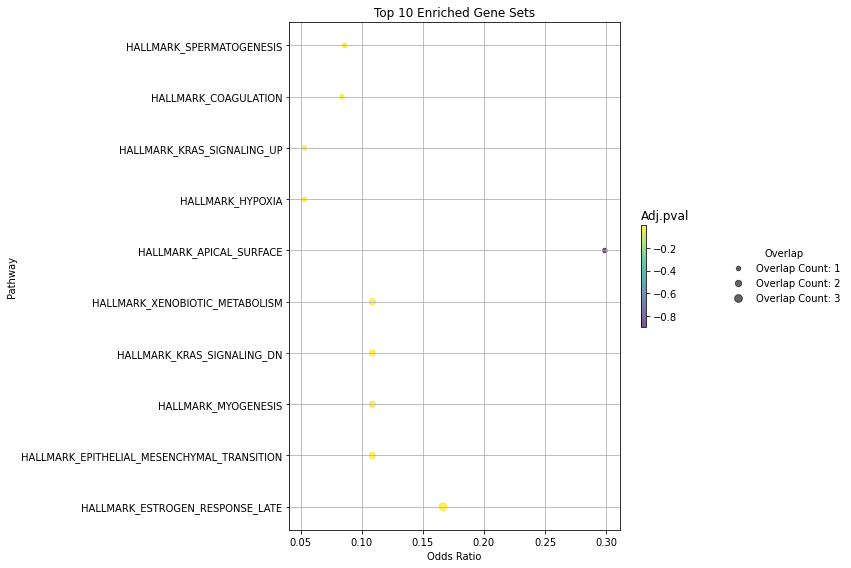

In [13]:
# Plot the scatter plot for the top 10 pathways
plt.figure(figsize=(12, 8))

# Main scatter plot
sc = plt.scatter(x, range(10), s=sizes, c=-adjusted_p_values, cmap='viridis', alpha=0.7)

# Set labels and title
plt.yticks(range(10), y_labels)  # Set y-axis labels to pathway names
plt.xlabel('Odds Ratio')
plt.ylabel('Pathway')
plt.title('Top 10 Enriched Gene Sets')

# Add a legend for dot sizes (overlap count) outside the plot
handles, labels = sc.legend_elements(prop="sizes", alpha=0.6)
legend_labels = [f'Overlap Count: {int(float(label.split("{")[1].split("}")[0]) // 20)}' for label in labels]
legend = plt.legend(handles, legend_labels, loc="center left", bbox_to_anchor=(1.3, 0.5), title="Overlap", frameon=False)

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.2)  # Shrink colorbar size
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_title('Adj.pval', loc='left') 

# Adjust layout to prevent overlap between legends
plt.subplots_adjust(right=0.75)  # Adjust the right margin to make space for the legends

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# KEGG Pathway Enrichment Analysis using Gseapy

In [14]:
kegg = gp.get_library(name='KEGG_2016', organism='Human')

In [15]:
kegg

{'Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate Homo sapiens hsa00532': ['CSGALNACT2',
  'CSGALNACT1',
  'CHST7',
  'CHPF2',
  'CHPF',
  'XYLT1',
  'B3GAT3',
  'XYLT2',
  'B3GALT6',
  'DSE',
  'UST',
  'CHST12',
  'CHSY3',
  'CHST13',
  'CHSY1',
  'CHST11',
  'CHST14',
  'CHST15',
  'B4GALT7',
  'CHST3'],
 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin Homo sapiens hsa00534': ['HS3ST3A1',
  'HS3ST1',
  'HS3ST3B1',
  'XYLT1',
  'B3GAT3',
  'GLCE',
  'XYLT2',
  'B3GALT6',
  'HS6ST1',
  'HS6ST2',
  'HS3ST5',
  'HS2ST1',
  'HS6ST3',
  'HS3ST2',
  'EXT1',
  'NDST3',
  'EXT2',
  'EXTL1',
  'NDST2',
  'NDST1',
  'EXTL3',
  'EXTL2',
  'NDST4',
  'B4GALT7'],
 'Glycosylphosphatidylinositol(GPI)-anchor biosynthesis Homo sapiens hsa00563': ['GPLD1',
  'DPM2',
  'PIGC',
  'PIGF',
  'PIGB',
  'PIGA',
  'PIGL',
  'PIGK',
  'PIGN',
  'PIGM',
  'PIGH',
  'PIGG',
  'PIGT',
  'PIGS',
  'PGAP1',
  'PIGV',
  'PIGU',
  'PIGP',
  'PIGO',
  'PIGQ',
  'GPAA1',
  'PIGX',
 

In [16]:
gene_sets

{'HALLMARK_ADIPOGENESIS': {'ABCA1',
  'ABCB8',
  'ACAA2',
  'ACADL',
  'ACADM',
  'ACADS',
  'ACLY',
  'ACO2',
  'ACOX1',
  'ADCY6',
  'ADIG',
  'ADIPOQ',
  'ADIPOR2',
  'AGPAT3',
  'AIFM1',
  'AK2',
  'ALDH2',
  'ALDOA',
  'ANGPT1',
  'ANGPTL4',
  'APLP2',
  'APOE',
  'ARAF',
  'ARL4A',
  'ATL2',
  'ATP1B3',
  'ATP5PO',
  'BAZ2A',
  'BCKDHA',
  'BCL2L13',
  'BCL6',
  'C3',
  'CAT',
  'CAVIN1',
  'CAVIN2',
  'CCNG2',
  'CD151',
  'CD302',
  'CD36',
  'CDKN2C',
  'CHCHD10',
  'CHUK',
  'CIDEA',
  'CMBL',
  'CMPK1',
  'COL15A1',
  'COL4A1',
  'COQ3',
  'COQ5',
  'COQ9',
  'COX6A1',
  'COX7B',
  'COX8A',
  'CPT2',
  'CRAT',
  'CS',
  'CYC1',
  'CYP4B1',
  'DBT',
  'DDT',
  'DECR1',
  'DGAT1',
  'DHCR7',
  'DHRS7',
  'DHRS7B',
  'DLAT',
  'DLD',
  'DNAJB9',
  'DNAJC15',
  'DRAM2',
  'ECH1',
  'ECHS1',
  'ELMOD3',
  'ELOVL6',
  'ENPP2',
  'EPHX2',
  'ESRRA',
  'ESYT1',
  'ETFB',
  'FABP4',
  'FAH',
  'FZD4',
  'G3BP2',
  'GADD45A',
  'GBE1',
  'GHITM',
  'GPAM',
  'GPAT4',
  'GPD2',
  'GPHN

The kegg results need to be reformatted into a dictionary for enrichment analysis:

In [17]:
# Initialise an empty dictionary to store pathway name: gene names pairs
pathway_dict = {}

# Iterate through the pathway_gene_dict and populate the pathway_dict
for pathway_name, gene_list in kegg.items():
    # Convert gene list to a set to remove duplicates
    gene_set = set(gene_list)
    # Assign gene set to pathway name in pathway_dict
    pathway_dict[pathway_name] = gene_set

# Display the resulting dictionary
print(pathway_dict)

{'Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate Homo sapiens hsa00532': {'B4GALT7', 'CHST13', 'CHST11', 'UST', 'XYLT1', 'CHST15', 'B3GALT6', 'B3GAT3', 'CHPF2', 'CHSY1', 'CHPF', 'CHST3', 'DSE', 'CHST12', 'CHST7', 'CSGALNACT1', 'CSGALNACT2', 'XYLT2', 'CHST14', 'CHSY3'}, 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin Homo sapiens hsa00534': {'B4GALT7', 'NDST4', 'HS2ST1', 'EXTL1', 'EXTL3', 'XYLT1', 'B3GALT6', 'HS3ST3A1', 'B3GAT3', 'HS3ST5', 'EXT2', 'HS6ST1', 'HS3ST2', 'NDST2', 'EXT1', 'HS3ST1', 'HS3ST3B1', 'NDST1', 'XYLT2', 'EXTL2', 'NDST3', 'HS6ST3', 'HS6ST2', 'GLCE'}, 'Glycosylphosphatidylinositol(GPI)-anchor biosynthesis Homo sapiens hsa00563': {'PIGB', 'PIGN', 'PIGS', 'PGAP1', 'PIGO', 'PIGP', 'PIGT', 'PIGV', 'PIGQ', 'PIGF', 'GPLD1', 'PIGL', 'PIGH', 'GPAA1', 'PIGY', 'PIGG', 'PIGA', 'PIGC', 'PIGX', 'PIGW', 'PIGM', 'DPM2', 'PIGK', 'PIGU', 'PIGZ'}, 'Steroid biosynthesis Homo sapiens hsa00100': {'DHCR7', 'FDFT1', 'SQLE', 'SOAT1', 'NSDHL', 'TM7SF2', 'EB

In [18]:
# Container for results
results = []

# Iterate over each module
for module_name, module_genes in modules.items():
    module_genes_in_expr = module_genes.intersection(datExpr.columns)
    
    # Check if module_genes_in_expr is empty to avoid issues
    if len(module_genes_in_expr) == 0:
        continue

    # Iterate over each gene set in the GMT file
    for gene_set_name, gene_set_genes in pathway_dict.items():
        overlap_genes = module_genes_in_expr.intersection(gene_set_genes)
        non_overlap_module_genes = module_genes_in_expr.difference(gene_set_genes)
        non_overlap_gene_set_genes = gene_set_genes.difference(module_genes_in_expr)

        # Calculate the contingency table
        a = len(overlap_genes)
        b = len(non_overlap_module_genes)
        c = len(non_overlap_gene_set_genes)
        d = len(set(datExpr.columns)) - (a + b + c)  # Adjust d to only consider genes in datExpr
        
        # Ensure all values in the contingency table are non-negative
        if a < 0 or b < 0 or c < 0 or d < 0:
            continue

         # Perform Fisher's exact test only if all values are non-negative
        contingency_table = [[a, b], [c, d]]
        odds_ratio = None
        if b * c != 0:
            odds_ratio = (a * d) / (b * c)
        
        results.append({
            'Module': module_name,
            'Gene Set': gene_set_name,
            'Overlap Count': a,
            'Odds Ratio': odds_ratio,
            'P-value': p_value
        })

In [19]:
# Convert results to DataFrame for further analysis
results_df = pd.DataFrame(results)

# Adjust p-values for multiple testing
results_df['Adjusted P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

# Display results
print(results_df)

         Module                                           Gene Set  \
0      Module_1  Glycosaminoglycan biosynthesis - chondroitin s...   
1      Module_1  Glycosaminoglycan biosynthesis - heparan sulfa...   
2      Module_1  Glycosylphosphatidylinositol(GPI)-anchor biosy...   
3      Module_1         Steroid biosynthesis Homo sapiens hsa00100   
4      Module_1  SNARE interactions in vesicular transport Homo...   
...         ...                                                ...   
5251  Module_18    One carbon pool by folate Homo sapiens hsa00670   
5252  Module_18          Sulfur relay system Homo sapiens hsa04122   
5253  Module_18            Sulfur metabolism Homo sapiens hsa00920   
5254  Module_18    Selenocompound metabolism Homo sapiens hsa00450   
5255  Module_18  Aminoacyl-tRNA biosynthesis Homo sapiens hsa00970   

      Overlap Count  Odds Ratio  P-value  Adjusted P-value  
0                 0         0.0      1.0               1.0  
1                 0         0.0      

In [20]:
# Filter for Module 1 and sort by overlap count
module_1_results = results_df[results_df['Module'] == 'Module_1']
top_10_enriched_gene_sets = module_1_results.sort_values(by='Overlap Count', ascending=False).head(10)

print(top_10_enriched_gene_sets)

       Module                                           Gene Set  \
135  Module_1   PI3K-Akt signaling pathway Homo sapiens hsa04151   
136  Module_1           Pathways in cancer Homo sapiens hsa05200   
48   Module_1                   Alcoholism Homo sapiens hsa05034   
73   Module_1         Dopaminergic synapse Homo sapiens hsa04728   
130  Module_1        Ras signaling pathway Homo sapiens hsa04014   
70   Module_1  Retrograde endocannabinoid signaling Homo sapi...   
71   Module_1        Glutamatergic synapse Homo sapiens hsa04724   
45   Module_1  Cytokine-cytokine receptor interaction Homo sa...   
47   Module_1  Transcriptional misregulation in cancer Homo s...   
96   Module_1       AMPK signaling pathway Homo sapiens hsa04152   

     Overlap Count  Odds Ratio  P-value  Adjusted P-value  
135              4    0.106645      1.0               1.0  
136              3    0.060914      1.0               1.0  
48               2    0.125125      1.0               1.0  
73         

In [21]:
# Extract data for plotting (top 10 pathways with highest overlap count)
top_10_enriched_gene_sets
y_labels = top_10_enriched_gene_sets['Gene Set']
x = top_10_enriched_gene_sets['Odds Ratio']
sizes = top_10_enriched_gene_sets['Overlap Count'] * 20
p_values = top_10_enriched_gene_sets['P-value']
adjusted_p_values = top_10_enriched_gene_sets['Adjusted P-value']

# Visualisation of KEGG Enrichment

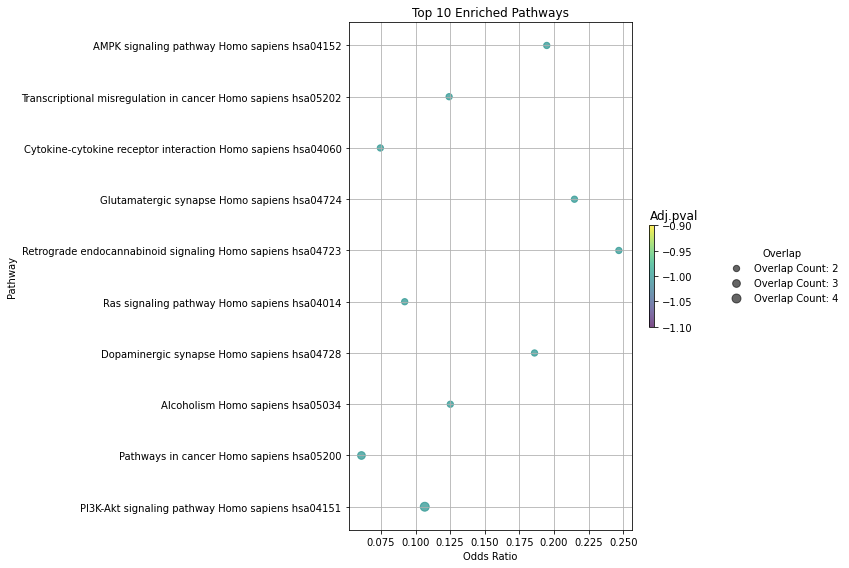

In [22]:
# Plot the scatter plot for the top 10 pathways
plt.figure(figsize=(12, 8))

# Main scatter plot
sc = plt.scatter(x, range(10), s=sizes, c=-adjusted_p_values, cmap='viridis', alpha=0.7)

# Set labels and title
plt.yticks(range(10), y_labels)  # Set y-axis labels to pathway names
plt.xlabel('Odds Ratio')
plt.ylabel('Pathway')
plt.title('Top 10 Enriched Pathways')

# Add a legend for dot sizes (overlap count) outside the plot
handles, labels = sc.legend_elements(prop="sizes", alpha=0.6)
legend_labels = [f'Overlap Count: {int(float(label.split("{")[1].split("}")[0]) // 20)}' for label in labels]
legend = plt.legend(handles, legend_labels, loc="center left", bbox_to_anchor=(1.3, 0.5), title="Overlap", frameon=False)

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.2)  # Shrink colorbar size
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_title('Adj.pval', loc='left') 

# Adjust layout to prevent overlap between legends
plt.subplots_adjust(right=0.75)  # Adjust the right margin to make space for the legends

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

External Reading:

- GSEA website: https://www.gsea-msigdb.org/gsea/index.jsp
- GSEA paper: https://www.pnas.org/doi/10.1073/pnas.0506580102
- Fisher exact test: https://www.pathwaycommons.org/guide/primers/statistics/fishers_exact_test/
- Odd's Ratio: https://www.ncbi.nlm.nih.gov/books/NBK431098/
- Alternative GSEA package: https://maayanlab.cloud/Enrichr/

Exercise Questions:
1. What is gene set enrichment analysis?
2. What is Fisher Exact Test?
3. What is the contingency table in Fisher's Exact Test, and how is it constructed for GSEA?
4. What does the odds ratio represent in the context of Fisher's Exact Test?
5. What are some potential limitations of using Fisher's Exact Test for enrichment analysis?
6. What are some alternatives to Fisher's Exact Test for enrichment analysis?
7. How does GSEA differ from use of Fisher Exact Test?
8. Enhance the visualisation of enrichment results. Plot a scatter plot for the top 10 enriched gene sets for Module 2. Customise the plot with different color maps and point markers. Annotate the top 3 most significant gene sets on the scatter plot with their names and p-values.
9. Think of a different way to visualise the enrichment results instead and plot them. For example, plot a heatmap of overlap counts across modules and gene sets.
10. Carry out a correlation analysis of enrichment scores across modules. Investigate the correlation between enrichment scores across different modules to understand how similarly different gene sets are enriched across various modules.

Answers:
1. GSEA is a computational method used to determine whether predefined sets of genes (gene sets) exhibit statistically significant differences in their expression between two or more biological states or conditions.
2. The Fisher Exact Test is a statistical significance test used to determine whether there are nonrandom associations between two categorical variables in a contingency table. 
3. A contingency table in Fisher's Exact Test is a 2x2 table that summarizes the counts of observations falling into four categories:
    - a: The number of genes that are both in the gene set and in the module.
    - b: The number of genes in the module but not in the gene set.
    - c: The number of genes in the gene set but not in the module.
    - d: The number of genes neither in the gene set nor in the module.

    For GSEA, the contingency table helps to compute the odds ratio and p-value, which quantify the enrichment of the gene set in the module.
4. The odds ratio represents the strength of the association between the gene set and the module. It is calculated as (a * d) / (b * c). A high odds ratio indicates a strong association, meaning that the gene set is more likely to be enriched in the module compared to random expectation.
5. Potential limitations include:
    - Small Sample Sizes: Fisher's Exact Test can be sensitive to very small sample sizes or low counts, leading to unstable results.
    - Dependency on Gene Set Size: Enrichment results can be influenced by the size of the gene set, with larger gene sets often showing more significant results due to the increased chance of overlap.
    - Multiple Testing: The risk of Type I errors increases when many tests are performed, which necessitates careful adjustment for multiple comparisons.
6. Alternatives to Fisher's Exact Test include:
    - Chi-Square Test: Suitable for larger sample sizes and when the expected frequencies are sufficiently high.
    - Hypergeometric Test: Often used in place of Fisher's Exact Test for larger gene sets, providing a similar assessment of enrichment.
    - Permutation-Based Methods: Used in GSEA to assess enrichment by comparing observed results to a distribution generated from randomised data.
7. GSEA focuses on analysing the collective behavior of genes within gene sets to uncover biologically relevant pathways or functional modules. Whereas Fisher Exact Test assesses the significance of associations between individual genes or genomic features and phenotypic categories. GSEA assesses the enrichment of gene sets by comparing the distribution of genes within each set to the overall distribution of genes ranked based on a statistical metric (e.g., differential expression score). It uses a running sum statistic or similar approach to calculate an enrichment score for each gene set and assesses statistical significance based on permutation testing or other methods. Whereas Fisher Exact Test alculates the probability of obtaining the observed distribution of frequencies in a contingency table under the null hypothesis of independence between two categorical variables. It uses the hypergeometric distribution to compute the probability of obtaining as extreme or more extreme frequencies than the observed frequencies.

Answer 8:

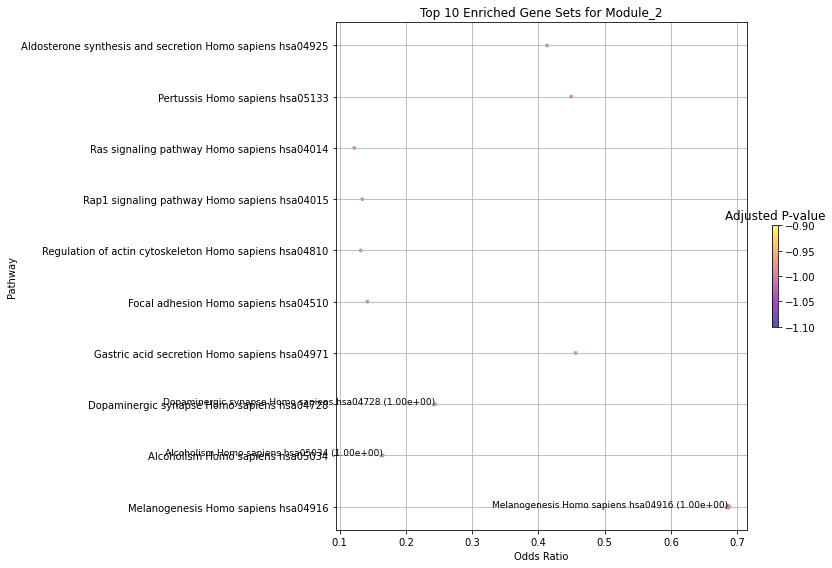

In [29]:
# Filter results for Module_2 and get top 10
module_2_results = results_df[results_df['Module'] == 'Module_2']
top_10_enriched_gene_sets = module_2_results.sort_values(by='Overlap Count', ascending=False).head(10)

# Plot with customisations
plt.figure(figsize=(12, 8))
sc = plt.scatter(
    top_10_enriched_gene_sets['Odds Ratio'],
    range(10),
    s=top_10_enriched_gene_sets['Overlap Count'] * 20,
    c=-top_10_enriched_gene_sets['Adjusted P-value'],
    cmap='plasma',
    alpha=0.7,
    edgecolors='w'
)
plt.yticks(range(10), top_10_enriched_gene_sets['Gene Set'])
plt.xlabel('Odds Ratio')
plt.ylabel('Pathway')
plt.title('Top 10 Enriched Gene Sets for Module_2')

# Annotate top 3
for i in range(3):
    plt.text(
        top_10_enriched_gene_sets['Odds Ratio'].iloc[i],
        i,
        f"{top_10_enriched_gene_sets['Gene Set'].iloc[i]} ({top_10_enriched_gene_sets['P-value'].iloc[i]:.2e})",
        fontsize=9,
        ha='right'
    )

# Add colorbar and show plot
cbar = plt.colorbar(sc, shrink=0.2)
cbar.ax.set_title('Adjusted P-value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# Example code for Hypergeometric test
results_hypergeo = []
for module_name, module_genes in modules.items():
    module_genes_in_expr = module_genes.intersection(datExpr.columns)
    for gene_set_name, gene_set_genes in gene_sets.items():
        overlap_genes = len(module_genes_in_expr.intersection(gene_set_genes))
        M = len(datExpr.columns)  # Total number of genes
        n = len(module_genes_in_expr)  # Number of genes in the module
        N = len(gene_set_genes)  # Number of genes in the gene set
        p_value = hypergeom.sf(overlap_genes-1, M, N, n)
        results_hypergeo.append({
            'Module': module_name,
            'Gene Set': gene_set_name,
            'Overlap Count': overlap_genes,
            'P-value': p_value
        })

results_hypergeo_df = pd.DataFrame(results_hypergeo)

In [31]:
results_hypergeo_df

,Module,Gene Set,Overlap Count,P-value
0,Module_1,HALLMARK_ADIPOGENESIS,0,1.0
1,Module_1,HALLMARK_ALLOGRAFT_REJECTION,0,1.0
2,Module_1,HALLMARK_ANDROGEN_RESPONSE,0,1.0
3,Module_1,HALLMARK_ANGIOGENESIS,0,1.0
4,Module_1,HALLMARK_APICAL_JUNCTION,1,1.0
...,...,...,...,...
895,Module_18,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0,1.0
896,Module_18,HALLMARK_UV_RESPONSE_DN,0,1.0
897,Module_18,HALLMARK_UV_RESPONSE_UP,0,1.0
898,Module_18,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0,1.0


Answer 9:

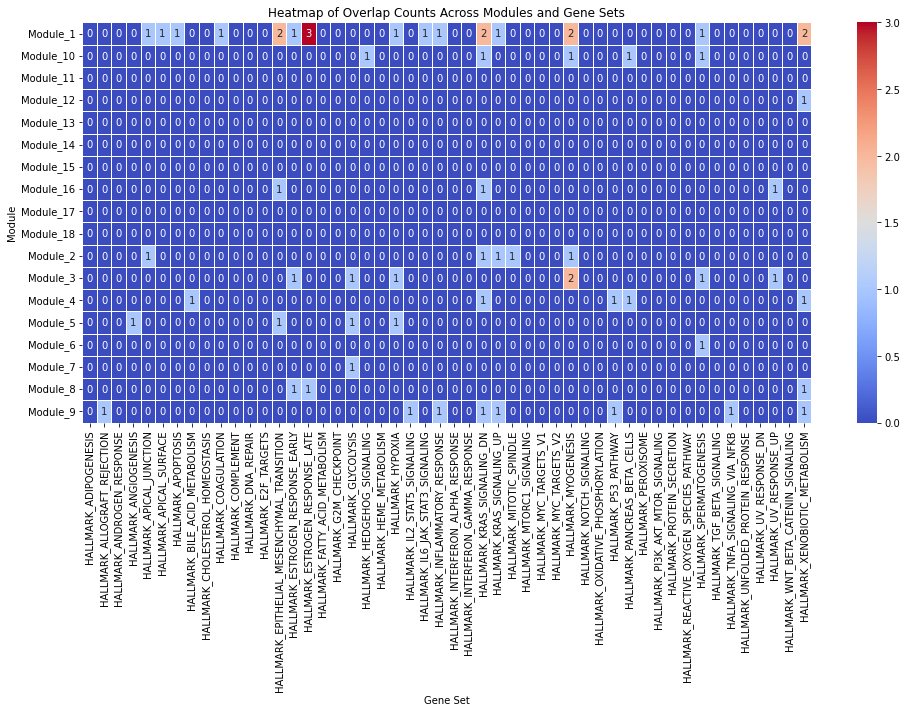

In [32]:
#Heatmap of Overlap Counts Across Modules and Gene Sets
heatmap_data = results_hypergeo_df.pivot_table(index='Module', columns='Gene Set', values='Overlap Count', fill_value=0)

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.xlabel('Gene Set')
plt.ylabel('Module')
plt.title('Heatmap of Overlap Counts Across Modules and Gene Sets')
plt.tight_layout()
plt.show()


Answer 10:

In [25]:
# Define the number of bootstrap samples
n_bootstraps = 50

# Initialize a list to store bootstrap results
bootstrap_results = []

# Original gene expression data
genes = datExpr.columns

# Perform bootstrap sampling
for _ in range(n_bootstraps):
    # Sample with replacement
    sampled_genes = np.random.choice(genes, size=len(genes), replace=True)
    
    # Create a bootstrap sample of the gene expression data
    bootstrap_sample = datExpr[sampled_genes]
    
    # Perform enrichment analysis on this bootstrap sample
    for module_name, module_genes in modules.items():
        module_genes_in_expr = module_genes.intersection(bootstrap_sample.columns)
        for gene_set_name, gene_set_genes in gene_sets.items():
            overlap_genes = len(module_genes_in_expr.intersection(gene_set_genes))
            M = len(bootstrap_sample.columns)
            n = len(module_genes_in_expr)
            N = len(gene_set_genes)
            p_value = hypergeom.sf(overlap_genes - 1, M, N, n)
            
            # Enrichment score: -log10(p-value) or another suitable metric
            enrichment_score = -np.log10(p_value) if p_value > 0 else np.nan
            
            bootstrap_results.append({
                'Module': module_name,
                'Gene Set': gene_set_name,
                'Overlap Count': overlap_genes,
                'P-value': p_value,
                'Enrichment Score': enrichment_score
            })

# Convert results to DataFrame
bootstrap_results_df = pd.DataFrame(bootstrap_results)


In [26]:
# Pivot table to get enrichment scores matrix
enrichment_matrix = bootstrap_results_df.pivot_table(
    index='Gene Set',
    columns='Module',
    values='Enrichment Score'
)

# Compute correlation matrix
correlation_matrix = enrichment_matrix.corr()

# Display correlation matrix
print(correlation_matrix)


Module     Module_1  Module_10  Module_11  Module_12  Module_13  Module_14  \
Module                                                                       
Module_1   1.000000  -0.041742        NaN  -0.020879        NaN        NaN   
Module_10 -0.041742   1.000000        NaN  -0.037196        NaN        NaN   
Module_11       NaN        NaN        NaN        NaN        NaN        NaN   
Module_12 -0.020879  -0.037196        NaN   1.000000        NaN        NaN   
Module_13       NaN        NaN        NaN        NaN        NaN        NaN   
Module_14       NaN        NaN        NaN        NaN        NaN        NaN   
Module_15       NaN        NaN        NaN        NaN        NaN        NaN   
Module_16 -0.039599  -0.001375        NaN  -0.035918        NaN        NaN   
Module_17       NaN        NaN        NaN        NaN        NaN        NaN   
Module_18       NaN        NaN        NaN        NaN        NaN        NaN   
Module_2  -0.054122   0.026869        NaN  -0.047324        NaN 

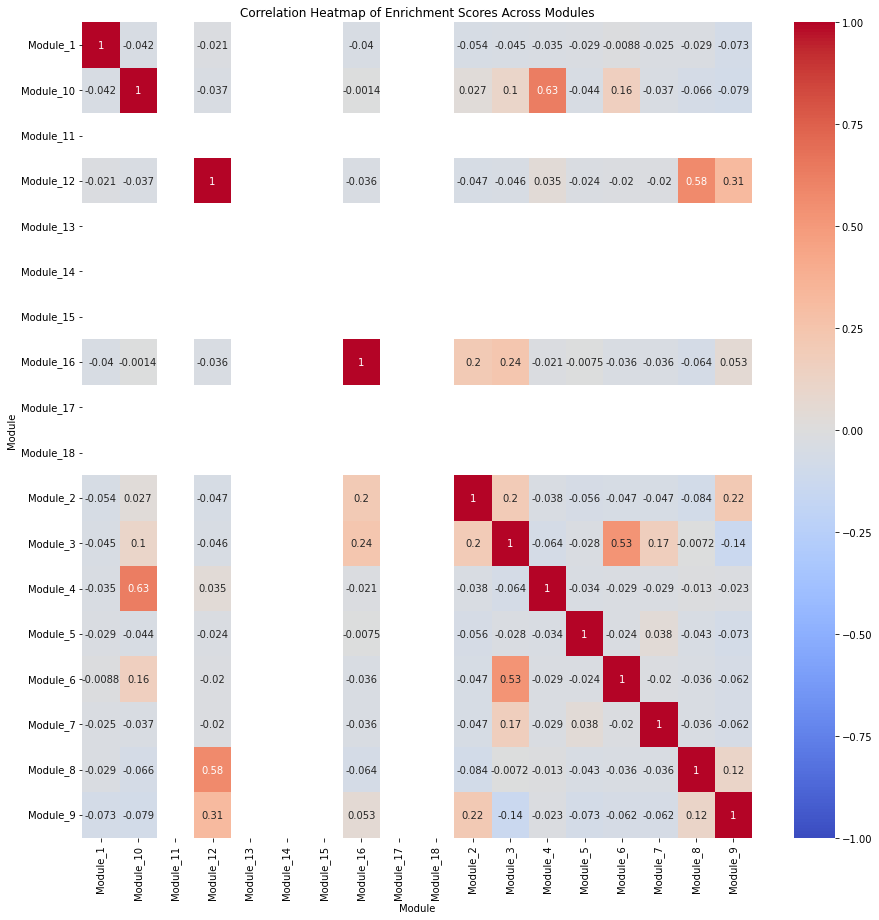

In [34]:
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Enrichment Scores Across Modules')
plt.show()


/tmp/ipykernel_129598/675437692.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


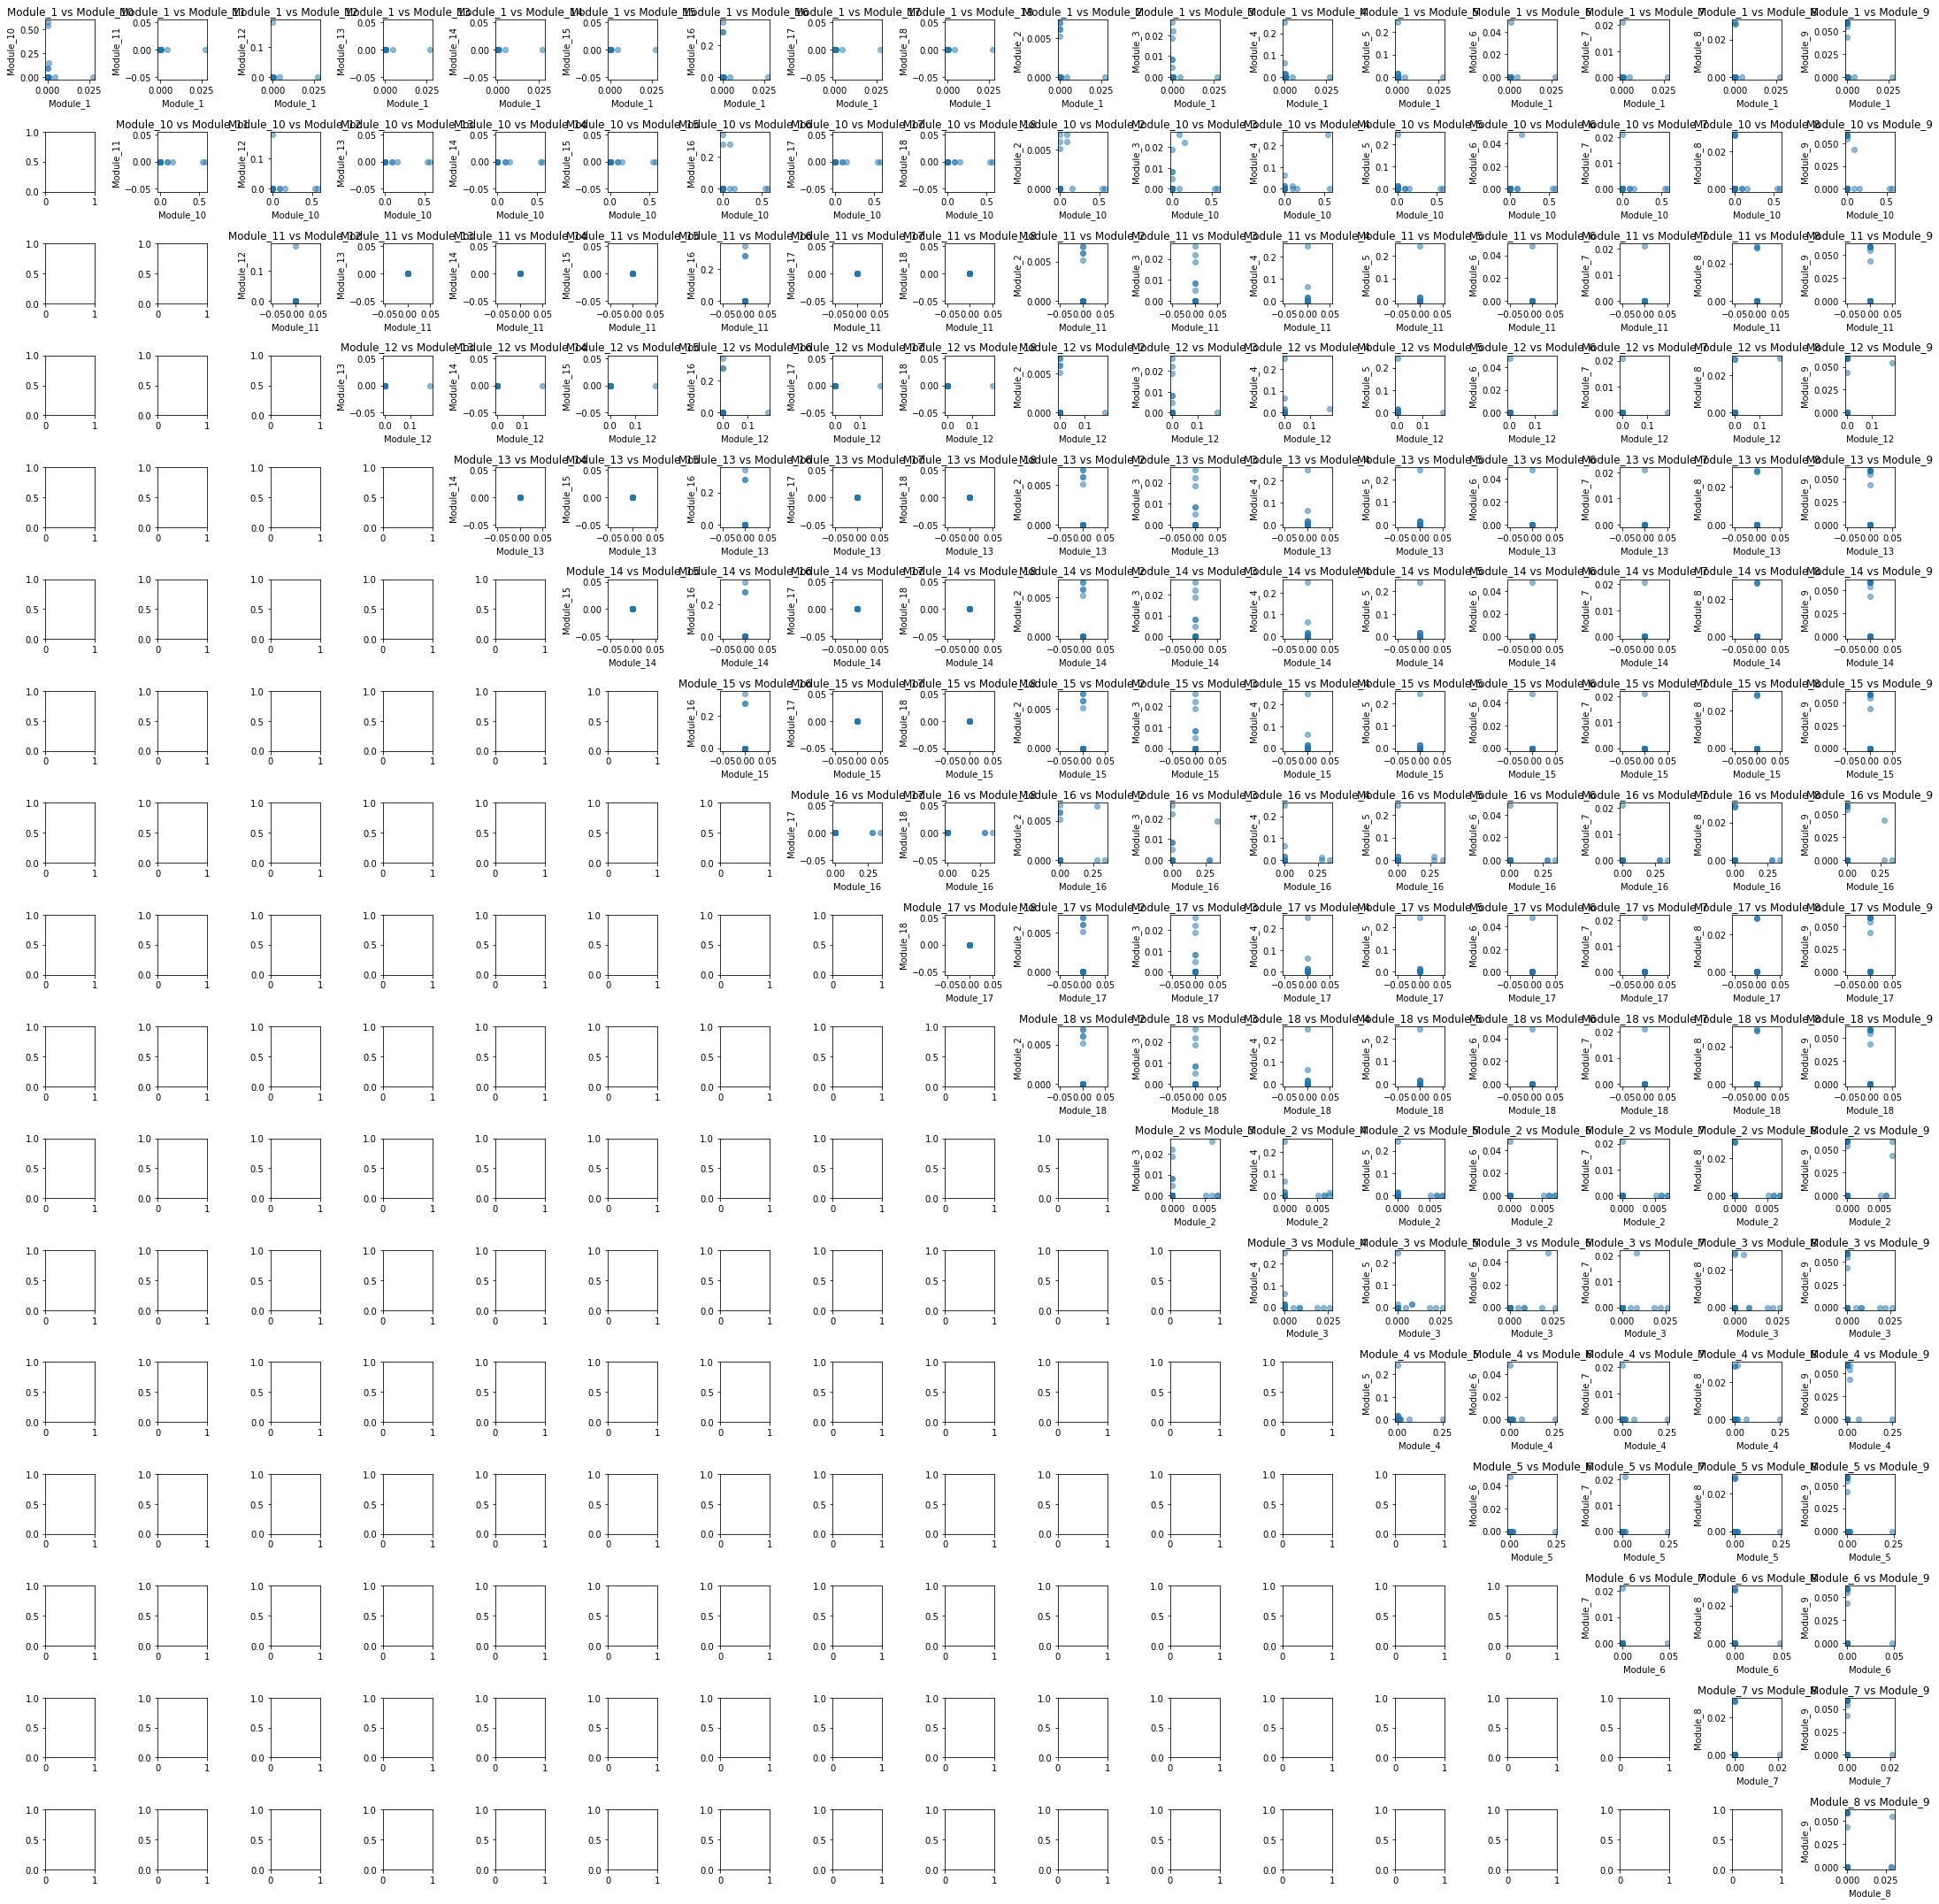

In [35]:
# List of module names
modules_list = correlation_matrix.columns
num_modules = len(modules_list)

# Ensure there is enough space for subplots
fig, axes = plt.subplots(num_modules - 1, num_modules - 1, figsize=(30, 30), constrained_layout=True)

# Create scatter plots for pairwise comparisons
for i in range(num_modules):
    for j in range(i + 1, num_modules):
        ax = axes[i, j - 1] if j > i else axes[j - 1, i]
        x = enrichment_matrix[modules_list[i]]
        y = enrichment_matrix[modules_list[j]]
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(modules_list[i])
        ax.set_ylabel(modules_list[j])
        ax.set_title(f'{modules_list[i]} vs {modules_list[j]}')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()
